# 📝 Handwritten Character Regconition using Machine Learning

This notebook will go through a machine learning project with the goal of classifying different handwritten characters including letters and digits.

To do this, we will be using data downloaded from [EMNIST (Extended MNIST)](https://www.kaggle.com/datasets/crawford/emnist). It consists of six different splits with details provided below: 
* EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
* EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
* EMNIST Balanced:  131,600 characters. 47 balanced classes.
* EMNIST Letters: 145,600 characters. 26 balanced classes.
* EMNIST Digits: 280,000 characters. 10 balanced classes.
* EMNIST MNIST: 70,000 characters. 10 balanced classes.

Visual breakdown of EMNIST datasets is specified as follow:
<img src="../report/images/emnistdataset.jpg" width="400" height="800">

Please refer to the [EMNIST: an extension of MNIST to handwritten letters](https://arxiv.org/abs/1702.05373v1) paper for more details of the dataset. 

In this project, the `EMNIST Balanced` dataset will be used to reduce mis-classification errors due to capital and lower case letters and also has an equal number of samples per class. The `EMNIST Balanced` includes two main datasets: 
* **emnist-balanced-train.csv** - 112,800 images 
* **emnist-balanced-test.csv** - 18,800 images

Each image is stored in `CSV` files using a separated row and 785 columns (first column represents the class lable )


In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

%matplotlib inline

import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import np_utils
import sklearn.metrics as metrics

from keras.models import load_model

In [27]:
train_data = pd.read_csv('../../data/emnist-balanced-train.csv')
test_data = pd.read_csv('../../data/emnist-balanced-test.csv')
mapp = pd.read_csv("../../data/emnist-balanced-mapping.txt", 
                   delimiter = ' ', index_col=0, header=None, squeeze=True)

In [3]:
train_data.head()

,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data.head()

,41,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.523,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532
0,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(f'Train: {train_data.shape}, Test: {test_data.shape}, Map: {mapp.shape}')

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [6]:
# Define width and height of images
WIDTH = 28
HEIGHT = 28

In [34]:
# Split X and y
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

In [35]:
print(f'Train data: {X_train.shape}')
print(f'Train labels: {y_train.shape}')
print(f'Test data: {X_test.shape}')
print(f'Train labels: {y_test.shape}')

Train data: (112799, 784)
Train labels: (112799,)
Test data: (18799, 784)
Train labels: (18799,)


In [36]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [37]:
# Flip and rotate image
X_train = np.asarray(X_train)
X_train = np.apply_along_axis(rotate, 1, X_train)
print(f'Train data: {X_train.shape}')

X_test = np.asarray(X_test)
X_test = np.apply_along_axis(rotate, 1, X_test)
print(f'Test data: {X_test.shape}')

Train data: (112799, 28, 28)
Test data: (18799, 28, 28)


In [38]:
# Normalize data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

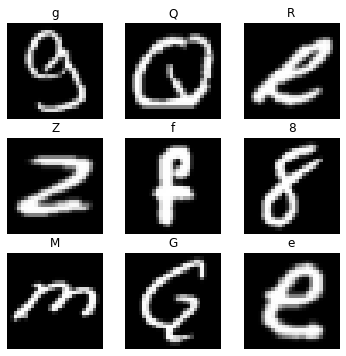

In [39]:
# Visualize data
samples = random.sample(range(0, len(X_train)), 9)

plt.figure(figsize=(6, 6))
for i in samples:
    plt.subplot(3, 3, samples.index(i) + 1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[y_train[i]]))
    plt.axis('off')

In [13]:
# number of classes
num_classes = y_train.nunique()

In [14]:
# One hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

y_train:  (112799, 47)
y_test:  (18799, 47)


In [15]:
# Reshaping for input to CNN
X_train = X_train.reshape(-1,HEIGHT,WIDTH,1)
X_test = X_test.reshape(-1,HEIGHT,WIDTH,1)

In [16]:
# Split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=42)

In [17]:
# Building model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), padding = 'same', activation='relu', input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

2022-12-17 16:41:57.915435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
705/705 [==============================] - 50s 71ms/step - loss: 1.2443 - accuracy: 0.6323 - val_loss: 0.4724 - val_accuracy: 0.8338
Epoch 2/10
705/705 [==============================] - 50s 70ms/step - loss: 0.6669 - accuracy: 0.7856 - val_loss: 0.4104 - val_accuracy: 0.8492
Epoch 3/10
705/705 [==============================] - 48s 69ms/step - loss: 0.5700 - accuracy: 0.8129 - val_loss: 0.3744 - val_accuracy: 0.8648
Epoch 4/10
705/705 [==============================] - 51s 72ms/step - loss: 0.5157 - accuracy: 0.8278 - val_loss: 0.3548 - val_accuracy: 0.8717
Epoch 5/10
705/705 [==============================] - 49s 70ms/step - loss: 0.4807 - accuracy: 0.8372 - val_loss: 0.3446 - val_accuracy: 0.8762
Epoch 6/10
705/705 [==============================] - 49s 69ms/step - loss: 0.4470 - accuracy: 0.8472 - val_loss: 0.3371 - val_accuracy: 0.8756
Epoch 7/10
705/705 [==============================] - 49s 69ms/step - loss: 0.4235 - accuracy: 0.8543 - val_loss: 0.3313 - val_accuracy:

In [20]:
# Save model 
model.save("cnn.h5")

In [21]:
# Load model
cnn_model = load_model("cnn.h5")

In [22]:
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3519884943962097
Test accuracy: 0.8795148730278015


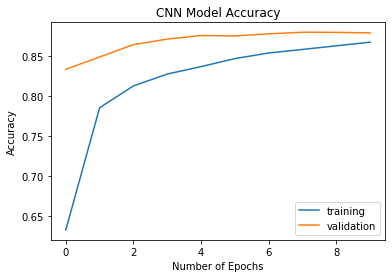

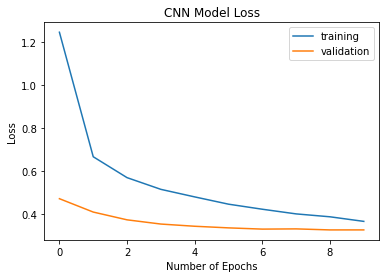

In [23]:
# Plot training vs validation accruacy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# Plot training vs validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [24]:
# Predict values for all data
predictions = model.predict(X_test)

588/588 [==============================] - 5s 8ms/step


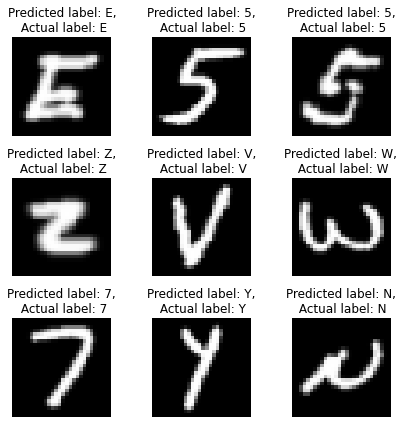

In [40]:
# Visualize our prediction on the test set
test_samples = random.sample(range(0, len(X_test)), 9)

fig = plt.figure(figsize=(6, 6))
for i in test_samples:
    plt.subplot(3, 3, test_samples.index(i) + 1)
    plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))
    plt.title(f'Predicted label: {chr(mapp[np.argmax(predictions[i])])},\n Actual label: {chr(mapp[y_test[i]])}')
    plt.axis('off')
    
# set spacing
fig.tight_layout()
plt.show()

## Visualize CNN Layers

In [41]:
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
feature_maps = feature_map_model.predict(X_train[123].reshape(1,28,28,1))

def display_feature_maps(feature_maps, layer_index=1):
    feature_map = feature_maps[layer_index-1]
    fig = plt.figure(figsize=(20, 15))
    for i in range(feature_map.shape[-1]):
        plt.subplot(8, feature_map.shape[-1] // 8, i + 1)
        plt.imshow(feature_map[0, :, :, i], cmap='gray')
        plt.axis('off')
        
    fig.suptitle(layer_names[layer_index-1])
    fig.tight_layout()
    plt.show()

1/1 [==============================] - 0s 60ms/step


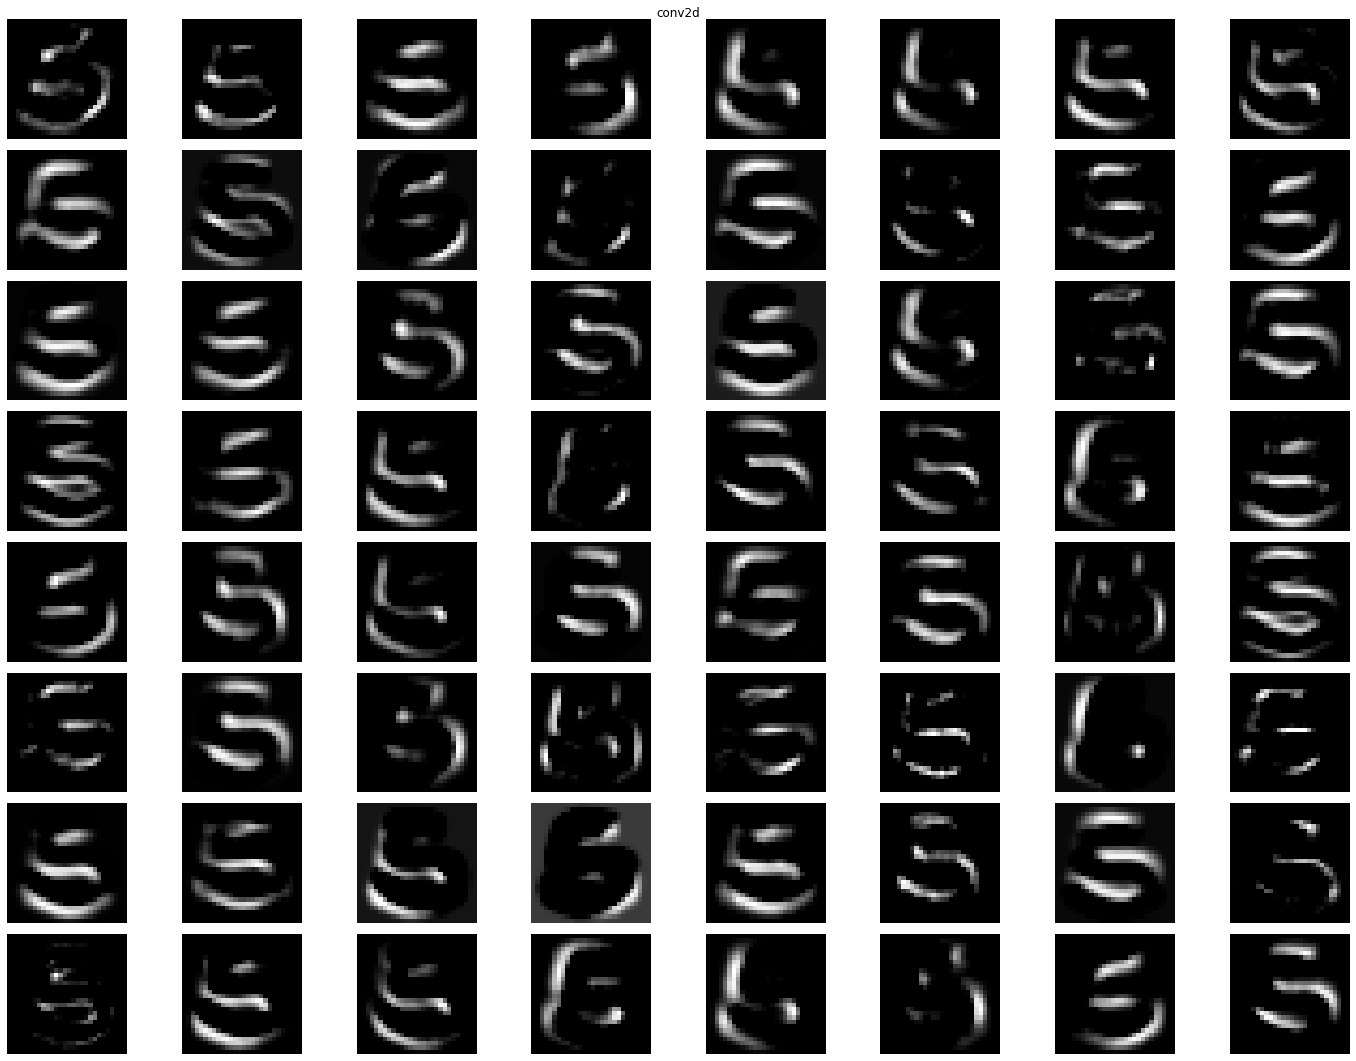

In [42]:
display_feature_maps(feature_maps, 1)

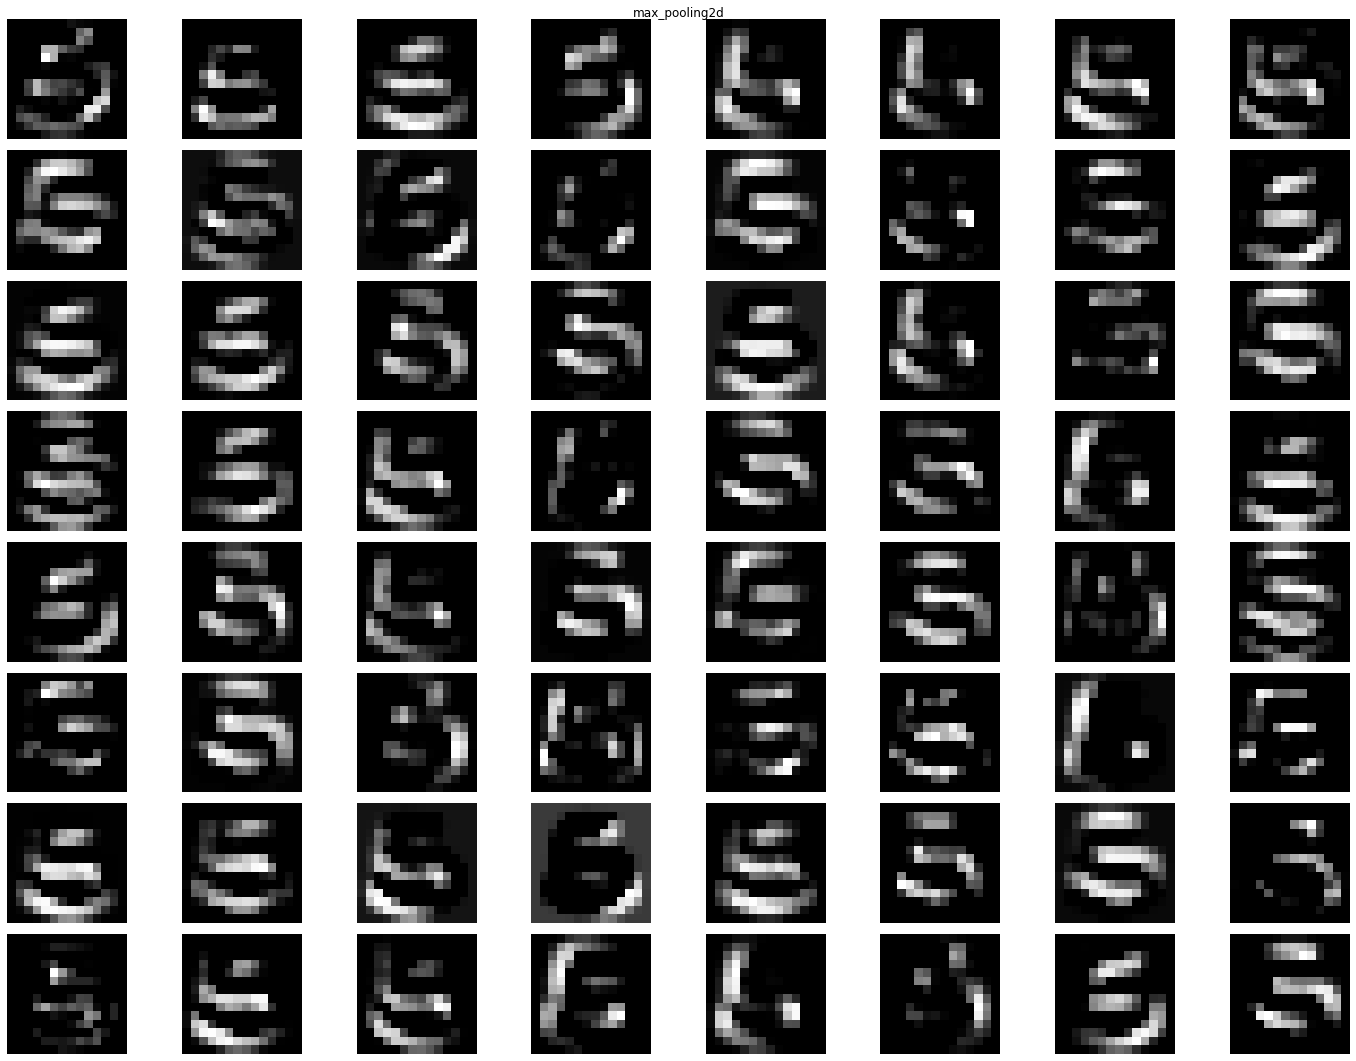

In [43]:
display_feature_maps(feature_maps, 2)

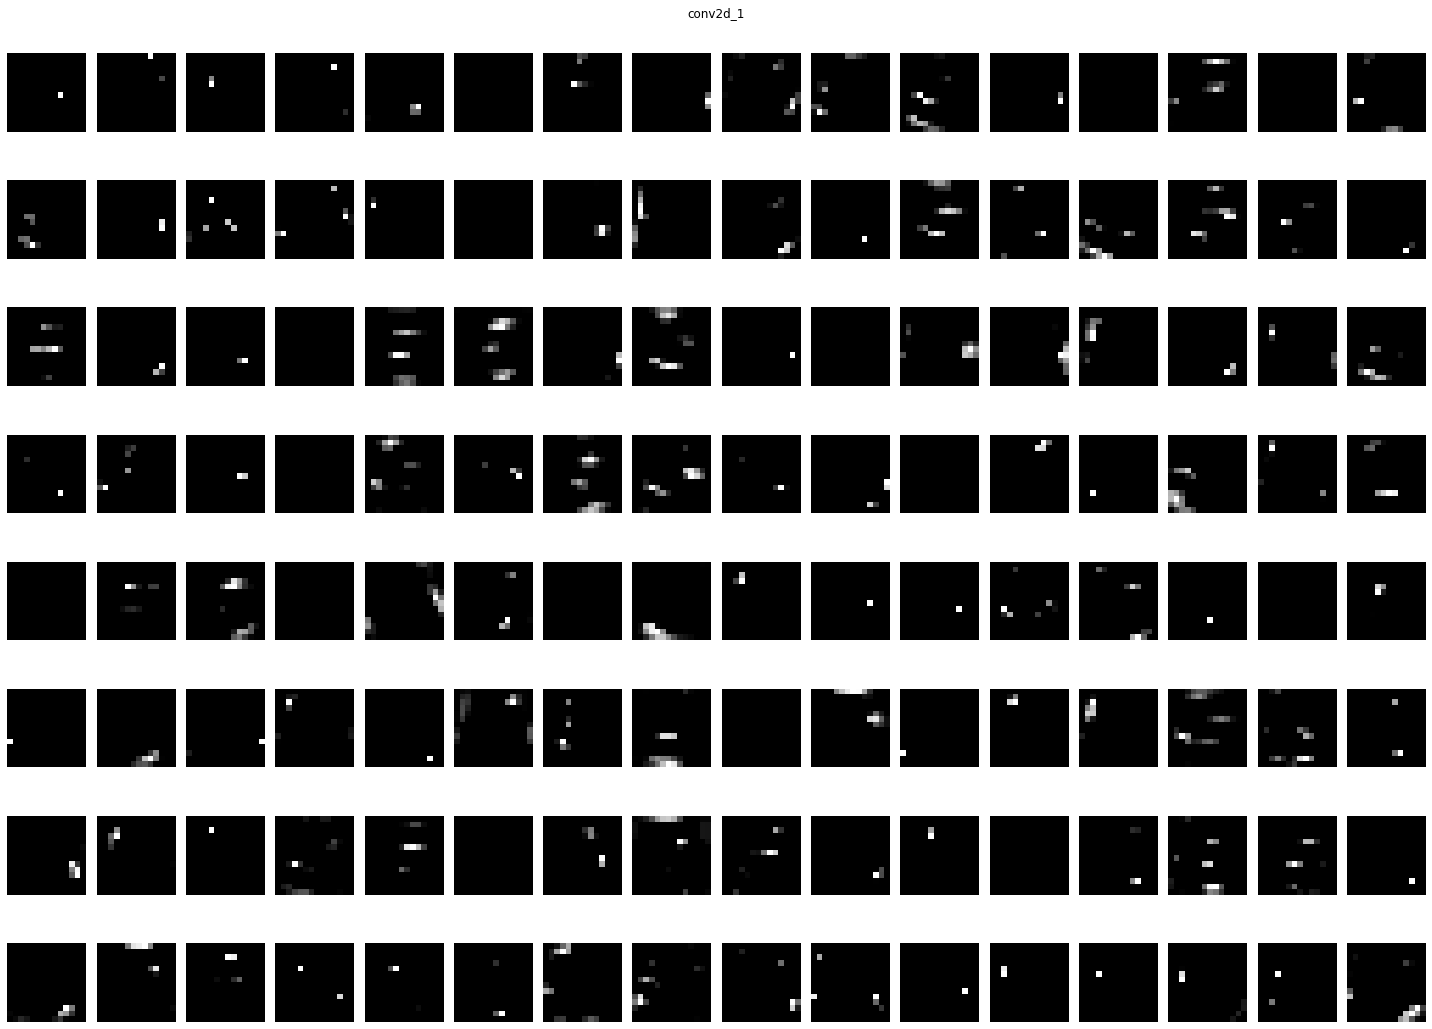

In [44]:
display_feature_maps(feature_maps, 3)

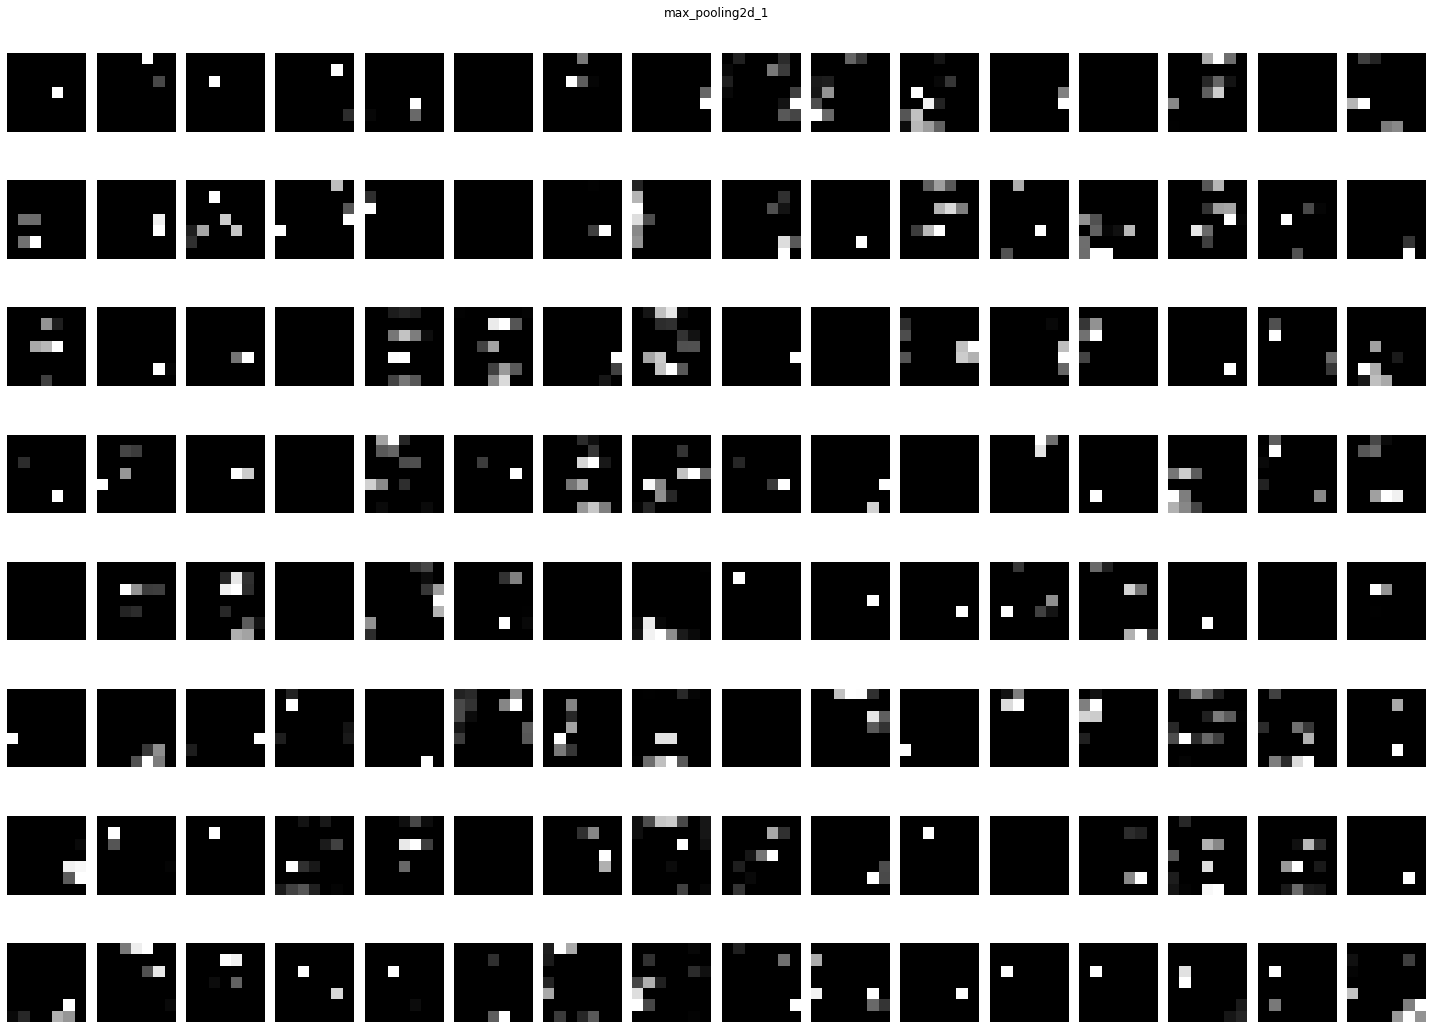

In [45]:
display_feature_maps(feature_maps, 4)

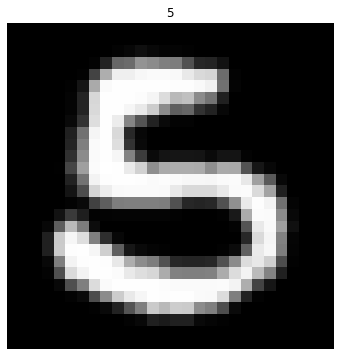

In [47]:
plt.figure(figsize=(6, 6))
plt.imshow(X_train[123], cmap=plt.get_cmap('gray'))
plt.title(chr(mapp[y_train[123]]))
plt.axis('off')
plt.show()